# Shailesh Bolduc
**Financial Services Case Study**

## Section 1
**Exploring the split test and starting a story**

We are maximizing revenue per decision. This is the primary KPI, but some secondary ones could be revenue per appointment, appointment rate, or click rate. We could have some guardrails like revenue per appt or revenue per decision.

The baseline that we are testing against is the average revenue per decision (or row) across all 3 \$\times\$ 3 = 9 CTAs. Is any one better than the total average?

In [ ]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv("mortgage_data.csv")
df.head()

,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrolledPage,scrollDepth,clickedCTA,scheduledAppointment,revenue,mortgageVariation
0,user_97048,Google,Safari,Mobile,152000,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",1,75,0,0,0,NaN
1,user_14393,Social,Safari,Mobile,140000,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,1,25,0,0,0,NaN
2,user_30959,Direct,Safari,Mobile,128000,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,1,75,0,0,0,NaN
3,user_88588,Google,Chrome,Mobile,205000,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,1,75,1,0,0,NaN
4,user_65965,Google,Safari,Mobile,373000,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,0,NaN


In [8]:
def map_version(s: str):
    match s[:3]:
        case "Fir":
            return "Version 2"
        case "Acc":
            return "Version 3"
        case "Get":
            return "Version 1"
        case _:
            return "Nan"

# changing text of the banner to a more interpretable category
df["ctaCopy"] = df["ctaCopy"].apply(lambda c: map_version(c))
# create combination variable
df["cta_combo"] = df["ctaCopy"] + ', ' + df["ctaPlacement"]


In [18]:
# aggregate by by some variables that contribute to kpis/secondaries
agg = df.groupby("cta_combo").agg(
    decisions = ('userId', 'count'),
    clicks = ('clickedCTA', 'sum'),
    appointments = ('scheduledAppointment', 'sum'),
    revenue = ('revenue', 'sum')
).reset_index()

agg['ctr'] = agg['clicks'] / agg['decisions']
agg['appt_rate'] = agg['appointments'] / agg['decisions']
agg['rev_per_appointment'] = np.where(agg['appointments']>0, agg['revenue'] / agg['appointments'], 0.0)
agg['rev_per_decision'] = agg['revenue'] / agg['decisions']

# sort by revenue per decisionn for each combo to see which has the highest overall
agg = agg.sort_values('rev_per_decision', ascending=False).reset_index(drop=True)

# create summary
total_decisions = df.shape[0]
baseline_rpd = df['revenue'].sum() / total_decisions
champion = agg.iloc[0]  # top row
champion_rpd = champion['rev_per_decision']
incremental_lift_per_decision = champion_rpd - baseline_rpd
incremental_pct = (incremental_lift_per_decision / baseline_rpd)
incremental_rev_over_all = incremental_lift_per_decision * total_decisions
summary = {
    'total_decisions': int(total_decisions),
    'baseline_rpd': float(baseline_rpd),
    'champion_cta_combo': champion['cta_combo'],
    'champion_decisions': int(champion['decisions']),
    'champion_rpd': float(champion_rpd),
    'incremental_lift_per_decision': float(incremental_lift_per_decision),
    'incremental_pct_vs_baseline': float(incremental_pct),
    'incremental_total_revenue_if_100pct_served': float(incremental_lift_per_decision * 100000)
}

Now, we will perform some simple bootstrapping for a 95% confidence interval to determine if the difference between this "champion" and the rest is significant. We have a lot of data, but bootstrapping is always a good idea.

In [20]:
def bootstrap(series: pd.Series, n: int=2000, seed=42):
    rng = np.random.default_rng(seed)
    length = len(series)
    samples = []
    for _ in range(n):
        samp = rng.choice(series, size=length, replace=True)
        samples.append(np.mean(samp))
    return np.array(samples)

champion_rows = df[df['cta_combo'] == champion['cta_combo']]['revenue'].values
rest_rows = df[df['cta_combo'] != champion['cta_combo']]['revenue'].values
boots_ch = bootstrap(champion_rows)
boots_rest = bootstrap(rest_rows)
diff_boots = boots_ch - boots_rest[:len(boots_ch)]
ci_lower, ci_upper = np.percentile(diff_boots, [2.5, 97.5])


Now to print out our results an compare.

In [23]:
print(agg[['cta_combo', 'decisions', 'revenue', 'rev_per_decision', 'ctr', 'appt_rate']].to_string(index=False))
print("\nSummary of Metrics:")
for k, v in summary.items():
    print(f"{k:<40}: {v}")

print(f"\n95% CI for Difference between Champion RPD and the Rest: [{ci_lower}, {ci_upper}]")

        cta_combo  decisions  revenue  rev_per_decision      ctr  appt_rate
Version 2, Bottom      11111   143390         12.905229 0.153092   0.056881
   Version 1, Top      11112   140910         12.680886 0.211753   0.060295
   Version 2, Top      11111   136520         12.286923 0.198452   0.054541
   Version 3, Top      11111   134675         12.120871 0.186482   0.054631
Version 2, Middle      11111   134125         12.071371 0.169922   0.053191
Version 1, Middle      11111   130595         11.753668 0.183332   0.057871
Version 1, Bottom      11111   129970         11.697417 0.154172   0.056701
Version 3, Middle      11111   126935         11.424264 0.161462   0.050671
Version 3, Bottom      11111   125915         11.332463 0.134821   0.051751

Summary of Metrics:
total_decisions                         : 100000
baseline_rpd                            : 12.03035
champion_cta_combo                      : Version 2, Bottom
champion_decisions                      : 11111
champion_rp

**Section 1 Write Up**

After analyzing the provided mortgage conversion data from Financial Services' A/B test, the **CTA combination of Banner Version 2 with a placement on the bottom of the page was the top performer with an average of \$12.90 in revenue per decision** (RPD) as opposed to the baseline across the entire dataset of \$12.03 in RPD. If this were *deployed site-wide to about 100 thousand visits, this could generate an incremental \$87,000*, assuming all users are served under this combination.

However, a 95% confidence interval for the difference in RPD between this champion CTA combination and the total dataset is [\$-0.06, \$2.04]. Since zero is in this confidence interval, this indicates only marginal confidence in the initial findings. **I recommend further testing or a small rollout on the scale of about 50% of users while testing and exploration of CTA combination personalization occurs.**

## Section 2
**Are there any standout variables that could increase predictive power towards key metrics?**

We will run grouped summaries by variables that could be important such as device type, annual income, visit count (do returning members convert more?), scrolling, and property type.

In [ ]:
def summary_metrics(group):
    '''Gives us a kpi/secondary kpi summary of any aggregation we make for this section'''
    return pd.Series({
        "users": len(group),
        "ctr": group["clickedCTA"].mean(),
        "appointment_rate": group["scheduledAppointment"].mean(),
        "total_revenue": group["revenue"].sum(),
        "rev_per_decision": group["revenue"].sum() / len(group)
    })

In [37]:
# see interactions with device type
device_summary = df.groupby("deviceType").apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# test new vs returning effects
df["user_type"] = np.where(df["visitCount"] > 1, "returning", "new")
visit_summary = df.groupby("user_type").apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# does the appearance of the cta influence behavior
scroll_summary = df.groupby("scrolledPage").apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# summarize effects of property type
property_summary = df.groupby("estimatedPropertyType").apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# create income classes to analyze by. Classes decided intuitively.
df["income_bucket"] = pd.cut(
    df["estimatedAnnualIncome"],
    bins=[0, 50000, 100000, 160000, np.inf],
    labels=["Low", "Middle", "Upper-Middle", "High"]
)
income_summary = df.groupby("income_bucket").apply(summary_metrics).sort_values("rev_per_decision", ascending=False)

print(device_summary)
print(visit_summary)
print(scroll_summary)
print(property_summary)
print(income_summary)

              users       ctr  appointment_rate  total_revenue  \
deviceType                                                       
Desktop     39966.0  0.206100          0.065881       574855.0   
Mobile      60034.0  0.150315          0.048039       628180.0   

            rev_per_decision  
deviceType                    
Desktop            14.383601  
Mobile             10.463737  
             users       ctr  appointment_rate  total_revenue  \
user_type                                                       
returning  39388.0  0.197827          0.066238       567845.0   
new        60612.0  0.156223          0.047977       635190.0   

           rev_per_decision  
user_type                    
returning         14.416701  
new               10.479608  
                users       ctr  appointment_rate  total_revenue  \
scrolledPage                                                       
1             89676.0  0.192482          0.061521      1203035.0   
0             10324.0  0.0

C:\Users\srbol\AppData\Local\Temp\ipykernel_30264\280095051.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  device_summary = df.groupby("deviceType").apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
C:\Users\srbol\AppData\Local\Temp\ipykernel_30264\280095051.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  visit_summary = df.groupby("user_type").apply(summary_metrics).sort_values("rev_pe

Next we'll look at some interaction terms to see if we can make any more targeted claims. This will also set us up for part 3 since interaction terms can help explain otherwise unexplained variance.

In [42]:
# device x cta combo
device_cta = df.groupby(["deviceType", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# income x cta combo
income_cta = df.groupby(["income_bucket", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# user type x cta combo
visit_cta = df.groupby(["user_type", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
# property x cta_combo
property_cta = df.groupby(["estimatedPropertyType", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)

print(device_cta)
print(income_cta)
print(visit_cta)
print(property_cta)

C:\Users\srbol\AppData\Local\Temp\ipykernel_30264\3046943068.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  device_cta = df.groupby(["deviceType", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
C:\Users\srbol\AppData\Local\Temp\ipykernel_30264\3046943068.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_cta = df.groupby(["income_bucket", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)
C:\Users\srbol\AppData\Local\Temp\ipyke

                               users       ctr  appointment_rate  \
deviceType cta_combo                                               
Desktop    Version 2, Bottom  4492.0  0.194791          0.067898   
           Version 3, Bottom  4381.0  0.172563          0.067564   
           Version 3, Middle  4478.0  0.201653          0.063421   
           Version 1, Middle  4413.0  0.226150          0.070927   
           Version 1, Bottom  4482.0  0.191209          0.069166   
           Version 2, Middle  4461.0  0.210043          0.064111   
           Version 2, Top     4425.0  0.218983          0.062825   
           Version 1, Top     4437.0  0.234393          0.066486   
           Version 3, Top     4397.0  0.205140          0.060496   
Mobile     Version 1, Top     6675.0  0.196704          0.056180   
           Version 3, Top     6714.0  0.174263          0.050789   
           Version 2, Bottom  6619.0  0.124792          0.049403   
           Version 2, Top     6686.0  0.184864  

C:\Users\srbol\AppData\Local\Temp\ipykernel_30264\3046943068.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  property_cta = df.groupby(["estimatedPropertyType", "cta_combo"]).apply(summary_metrics).sort_values("rev_per_decision", ascending=False)


**Section 2 Write Up**

The goal of this analysis is to determine the correlations between certain groups or characteristics and revenue per decision as well as engagement overall. These are useful for initial results to communicate to people involved in the project as well as for the next step: modelled personalization.

Across the entire dataset, there were some clear trends that emerged in RPD.


$\bullet$ $\textbf{Device Type}$ </br> 
$\quad \bullet$ Desktop users generated significantly higher value than mobile users. (RPD: \$14.38 vs \$10.46). </br> 
$\quad \bullet$ When paired with the specific CTA combination each user saw, desktop users who saw Version 2 with bottom placement had the highest RPD of desktop users at \$15.38 per decision on average. For mobile users, this combination was still lucrative, but the combination of Version 1 with a top placement proved to yield the highest RPD at \$11.38 per decision. </br> 
$\quad \bullet$ Desktop users were also generally more engaged with their higher click rate. </br> 

$\bullet$ $\textbf{User Type}$ </br> 
$\quad \bullet$ Unsurprisingly, returning visitors had a higher RPD than new users (\$14.41 vs \$10.47).  </br> 
$\quad \bullet$ For both categories, returning and new, Version 2 with a bottom placement had the second highest RPD, but also for both, Version 1 with a top placement had the highest RPD. Returning users saw an RPD of \$15.73 while new users saw an RPD of \$11.44. </br> 

$\bullet$ $\textbf{Scroll Behavior}$ </br> 
$\quad \bullet$ Users who continued to scroll after the CTA loaded generated much more revenue. This is trivial, though, since users who did not scroll after the CTA loaded may not have even seen it. </br> 
$\quad \bullet$ Since this is a primarily categorical step of the analysis, during modeling we can explore scroll depth which is a numerical variable that could contribute significantly to RPD determination. </br> 

$\bullet$ $\textbf{Property Type}$ </br> 
$\quad \bullet$ Apartment holders by far had a higher RPD than even the second highest property type, townhomes, at \$13.41 per decision versus townhomes' \$11.51 per decision. </br> 
$\quad \bullet$ Among apartment holders, Version 2 of the CTA was by far the most effective across all placements with the bottom placement yielding the highest RPD at \$18.45 per decision. </br> 

$\bullet$ $\textbf{Income}$ </br> 
$\quad \bullet$ High-income users had the highest RPD and each income group followed consecutively after that. High-income users had an RPD of \$15.08 while upper-middle-income users had an RPD of upper-middle. </br> 
$\quad \bullet$ Among high-income users, Version 3 of the CTA was by far the most effective across all placements with the middle placement yielding the highest RPD at \$21.57 per decision. </br> 

Overall, these patterns validate the hypothesis from step 1 that user context significantly impacts revenue, more so than any one CTA combination. For example, implementing the Version 2 Bottom Placement combination immediately would lose engagement on all most high-income users since Version 3 performed better across all placements with high-income users.

Therefore, we should proceed with a personalization effort via predictive modeling of key metrics.

## Section 3
**Predicting the optimal CTA to maximize revenue**

We cannot go immediately from an array of user traits to optimal CTA combination. There must be an intermediate step. Thus, we will train a regression for each of the 9 CTA combinations to predict RPD of that CTA combination given user traits. Then, we will recommend the optimal CTA combination for the user to be the greatest of these 9 regressions given their characteristics.

The goal of this step is not to be abel to explain what traits of a user are contributing to higher RPD. That's what step 2 and 1 were for. The goal is to maximize RPD by presenting a user with the most optimal CTA combination. As a result, I will prioritize recommendation accuracy as opposed to recommendation interpretability.

Furthermore, this is a personalization model that will run in real time before a page is even rendered. Therefore, we can only use features that are known at the time a request is made to the Financial Services servers. This means things like scrolledPage, scrollDepth, or clickedCTA *cannot* be used or else we risk creating a data leakage which will lead to overperformance in training but bad real-world performance.

First, we will predict the probability that a user even schedules an appointment. Then, we can predict revenue per CTA given a user probably schedules an appointment. The model for this prediction is below:

$$
\begin{align*}
    \mathbf{E}[\text{Revenue | CTA}] = \mathbf{P}(\text{Appointment | CTA and Traits}) \times \mathbf{E}[\text{Revenue | Appointment, CTA, Traits}]
\end{align*}
$$

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Set our predictor variables

In [76]:
preds = ['user_type', 'deviceType', 'browser',
         'estimatedAnnualIncome', 'estimatedPropertyType','sessionReferrer']
df["returning_user"] = df['user_type'].map({'returning': 1, 'new': 0})
# technically, returning_user is categorical, but it's already binary
categorical_cols = ['deviceType', 'browser', 'estimatedPropertyType', 'sessionReferrer']
enc = OneHotEncoder(drop='first', sparse_output=False)
encoded = enc.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(categorical_cols))
# all predictive features
X = pd.concat([df[['returning_user','estimatedAnnualIncome']], encoded_df], axis=1)

In [57]:
# use 80% for training size. Separate by cta_combo column
X_train, X_test, y_train, y_test = train_test_split(X, df, test_size=0.2, random_state=42, stratify=df['cta_combo'])

Start Training the Logistic Regression that Predicts Appointments Scheduled

In [77]:
cta_combos = df['cta_combo'].unique()
logreg_models = {}

for cta in cta_combos:
    mask = y_train['cta_combo'] == cta
    X_cta = X_train.loc[mask]
    y_cta = y_train.loc[mask, 'scheduledAppointment'].astype(int)
    
    logreg = LogisticRegression(max_iter=500, random_state=42)
    logreg.fit(X_cta, y_cta)
    logreg_models[cta] = logreg
    print(f"Trained logistic regression for {cta}, samples: {len(y_cta)}")

Trained logistic regression for Version 2, Middle, samples: 8889
Trained logistic regression for Version 3, Bottom, samples: 8889
Trained logistic regression for Version 1, Middle, samples: 8889
Trained logistic regression for Version 3, Top, samples: 8889
Trained logistic regression for Version 1, Bottom, samples: 8889
Trained logistic regression for Version 1, Top, samples: 8889
Trained logistic regression for Version 3, Middle, samples: 8888
Trained logistic regression for Version 2, Bottom, samples: 8889
Trained logistic regression for Version 2, Top, samples: 8889


Start Training a Random Forest Model

Random Forest, while not directly interpretable like ordinary least squares, still does rank feature importances, isn't skewed by outliers, and can capture some more complex relationships like interactions.

In [ ]:
rf_models = {}
for cta in cta_combos:
    # only use records with this cta combo that also scheduled an appointment
    mask = (y_train['cta_combo'] == cta) & (y_train['scheduledAppointment'] == 1)
    X_cta = X_train.loc[mask]
    y_cta = y_train.loc[mask, 'revenue']
    # in case there are too few people that even scheduled an appointment within a particular combo
    if len(y_cta) < 30:
        continue
    # use log(1+revenue) to scale the unbalanced data
    y_cta_log = np.log1p(y_cta)

    # run regression
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1)
    rf.fit(X_cta, y_cta_log)
    rf_models[cta] = rf
    print(f"Trained RF for {cta}, samples: {len(y_cta)}")

Trained RF for Version 2, Middle, samples: 484
Trained RF for Version 3, Bottom, samples: 469
Trained RF for Version 1, Middle, samples: 525
Trained RF for Version 3, Top, samples: 469
Trained RF for Version 1, Bottom, samples: 503
Trained RF for Version 1, Top, samples: 548
Trained RF for Version 3, Middle, samples: 459
Trained RF for Version 2, Bottom, samples: 521
Trained RF for Version 2, Top, samples: 486


Generate Predictions

In [81]:
X_test_df = X_test.copy()
predictions = pd.DataFrame(index=X_test_df.index)

for cta in cta_combos:
    if cta in logreg_models and cta in rf_models:
        # P(appt)
        p_appt = logreg_models[cta].predict_proba(X_test)[:,1]
        # P(revenue | appt)
        pred_rev = np.expm1(rf_models[cta].predict(X_test))
        # formula provided at start of this section
        predictions[cta] = p_appt * pred_rev

# get the recommendation and rpd of each user in the test set
predictions["predicted_rpd"] = predictions.max(axis=1)
predictions["personalized_cta"] = predictions.idxmax(axis=1)
predictions.head()

,"Version 2, Middle","Version 3, Bottom","Version 1, Middle","Version 3, Top","Version 1, Bottom","Version 1, Top","Version 3, Middle","Version 2, Bottom","Version 2, Top",predicted_rpd,personalized_cta
26826,22.511624,16.426024,17.974274,13.390761,20.527888,19.509148,10.337555,31.800194,17.101869,31.800194,"Version 2, Bottom"
22633,22.943342,15.336024,17.251041,12.904464,19.259040,18.268373,13.864614,22.056524,25.446250,25.446250,"Version 2, Top"
17726,3.206902,3.377872,4.436188,4.318643,3.074682,4.387897,2.825958,3.395457,3.584335,4.436188,"Version 1, Middle"
89118,11.612141,6.309113,8.437220,6.979396,8.563189,10.697497,5.750451,12.912270,11.994430,12.912270,"Version 2, Bottom"
81538,18.507878,16.834789,19.148306,12.929727,21.339482,23.818757,11.226416,22.587815,22.268453,23.818757,"Version 1, Top"


Compare Against the Baseline Champion from Part 1

In [82]:
champ = champion["cta_combo"]
baseline_rpd = predictions[champ].mean()
personalized_rpd = predictions['predicted_rpd'].mean()
print(f"Expected RPD using Champion from Part 1 (Version 2, Bottom): {baseline_rpd:.2f}")
print(f"Expected RPD using Personalized CTA Combinations: {personalized_rpd:.2f}")
print(f"Difference: {personalized_rpd - baseline_rpd:.2f} ({100*(personalized_rpd - baseline_rpd)/baseline_rpd:.1f}% increase)")

Expected RPD using Champion from Part 1 (Version 2, Bottom): 12.92
Expected RPD using Personalized CTA Combinations: 16.62
Difference: 3.70 (28.6% increase)


Evaluate Revenue Model Performance

In [86]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [96]:
results = []
for cta in cta_combos:
    # only use records with this cta combo that also scheduled an appointment
    mask = y_train['cta_combo'] == cta
    X_cta = X_train.loc[mask]
    y_cta = y_train.loc[mask, 'revenue']
    y_cta = np.log1p(y_cta)

    y_pred = rf_models[cta].predict(X_cta)

    rmse_log = np.sqrt(mean_squared_error(y_cta, y_pred))

    # use original scale for interpretability
    MAX_LOG_REVENUE = np.log1p(df['revenue'].max() * 1.2)  # prevent float overflows
    y_pred_clip = np.clip(y_pred, 0, MAX_LOG_REVENUE)
    y_test_actual = np.expm1(y_cta)
    y_pred_actual = np.expm1(y_pred_clip)

    rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)

    results.append({
        "cta_combo": cta,
        "num_samples": len(y_cta),
        "rmse_log": rmse_log,
        "rmse_actual": rmse_actual,
        "mae_actual": mae_actual
    })

results_df = pd.DataFrame(results).sort_values("rmse_actual", ascending=False)
results_df

,cta_combo,num_samples,rmse_log,rmse_actual,mae_actual
8,"Version 2, Top",8889,5.259914,219.120712,213.636757
7,"Version 2, Bottom",8889,5.248192,218.646191,212.977574
0,"Version 2, Middle",8889,5.255266,218.067930,212.564453
1,"Version 3, Bottom",8889,5.207932,211.147988,203.527747
3,"Version 3, Top",8889,5.199273,209.332404,201.891994
6,"Version 3, Middle",8888,5.199396,207.648007,200.925554
5,"Version 1, Top",8889,5.183279,206.959918,200.633228
4,"Version 1, Bottom",8889,5.164303,199.693425,194.417396
2,"Version 1, Middle",8889,5.149621,198.667409,192.625532


In [97]:
print(f"Weighted RMSE (revenue): {np.mean(results_df["rmse_actual"])}")

Weighted RMSE (revenue): 209.92044252499844


In [91]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_models["Version 1, Middle"].feature_importances_
}).sort_values(by='importance', ascending=False)
importances

,feature,importance
1,estimatedAnnualIncome,0.978231
10,sessionReferrer_Google,0.007707
2,deviceType_Mobile,0.004424
0,returning_user,0.003981
6,estimatedPropertyType_House,0.003313
5,browser_Safari,0.001774
9,sessionReferrer_Email,0.000569
3,browser_Edge,0.000000
7,estimatedPropertyType_Mobile Home,0.000000
4,browser_Firefox,0.000000


Generate Predictions for Entire Dataset and Calculate Revenue Increase

In [92]:
preds_full = pd.DataFrame(index=X.index)
# P(appt)
p_appt = logreg_models[cta].predict_proba(X_test)[:,1]
# P(revenue | appt)
pred_rev = np.expm1(rf_models[cta].predict(X_test))
# formula provided at start of this section
predictions[cta] = p_appt * pred_rev
for cta in cta_combos:
    # P(appt)
    p_appt = logreg_models[cta].predict_proba(X)[:,1]
    # P(revenue | appt)
    pred_rev = np.expm1(rf_models[cta].predict(X))
    # formula provided at start of this section
    preds_full[cta] = p_appt * pred_rev

preds_full["predicted_rpd"] = preds_full.max(axis=1)
preds_full["personalized_cta"] = preds_full.idxmax(axis=1)

In [93]:
sum(preds_full["predicted_rpd"])

1663404.0164064297

In [94]:
sum(df["revenue"])

1203035

**Section 3 Write Up**

## Objective

The goal of this stage is to move beyond a single "champion" CTA combination and to pesonalize the combination for each user to maximize RPD. The model I developed selects the most profictable CTA combination for each individual user based on characters that we know at the time that they've enter the site before the content has rendered.

## Modeling Overview

Consisted of two stages:

### Appointment Probability Model

- Logistic regression
- Predicted the probability that a user would schedule an appointment
- Uses only features known before the CTA is placed

### Revenue Model

- Random Forest regression
- Created one model per CTA combination to select the best
- Trained on log(1 + revenue) to deal with large class imbalance (94.4% zero-revenue users)

### Final Inference

- Apply all 9 models to find which CTA combination would extract the most revenue from this user.

### Model Performance

Most important predictors:
- estimatedAnnualIncome: .978
- sessionReferrer_Google: .0077
- deviceType_Mobile: .0044
- returning_user: .0040

Root Mean Square Error: \$209.92.

While large, this dataset has a heavy class imbalance and inherently noisy outcomes. The model's goal, however, is not perfect prediction. It's to rank users and CTA combinations effectively which is shown by the final RPD increase in the conclusion.


# Conclusion



Rather than relying on a single champion call-to-action combination, I developed a personalization framework that can select the most optimal CTA combination for a user based on some of their traits to maximize revenue per decision.

The results of the study demonstrate that personalizing the layout delivers a significant improvement over the current layout or "sole champion" layout from Section 1 of the study. While the best-performing CTA from Section 1, banner version 2 with a bottom placement, yielded an expected RPD of $12.92, the personalized approach yielded an expected $16.62 in RPD, a 28.6% increase per user! When applied to the entire dataset, this corresponds to an **expected increase in total revenue from $1,203,035 originally to $1,663,404***. This is a total increase of $460,369.

It is important to note that the personalization model relies exclusively on entry-time information about users. Only variables that Financial Systems' servers or website can obtain or calculate before rendering a layout were used, making able to be realistically deployed in production without overfitting to the provided training data.

I also found that estimated annual income is by far the most important feature in predicting revenue. This aligns with the values obtained in Part 2 of the study as well as just general intuition about products and mortgage spending. This validates the model in that we can be confident that the model has learned meaningful information. Not just random correlations.

In sum, this project has demonstrated that **data-driven personalization of the CTA banner and placement layout is a very effective tool for driving increased revenue** in the mortgage services of Financial Services. The chart below demonstrates how just about the top 6% of users contributed to all of the revenue, whereas with CTA layout personalization the revenue may be more spread out in practice which not means more users are engaged with the content, but more conversions are made.

In [103]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

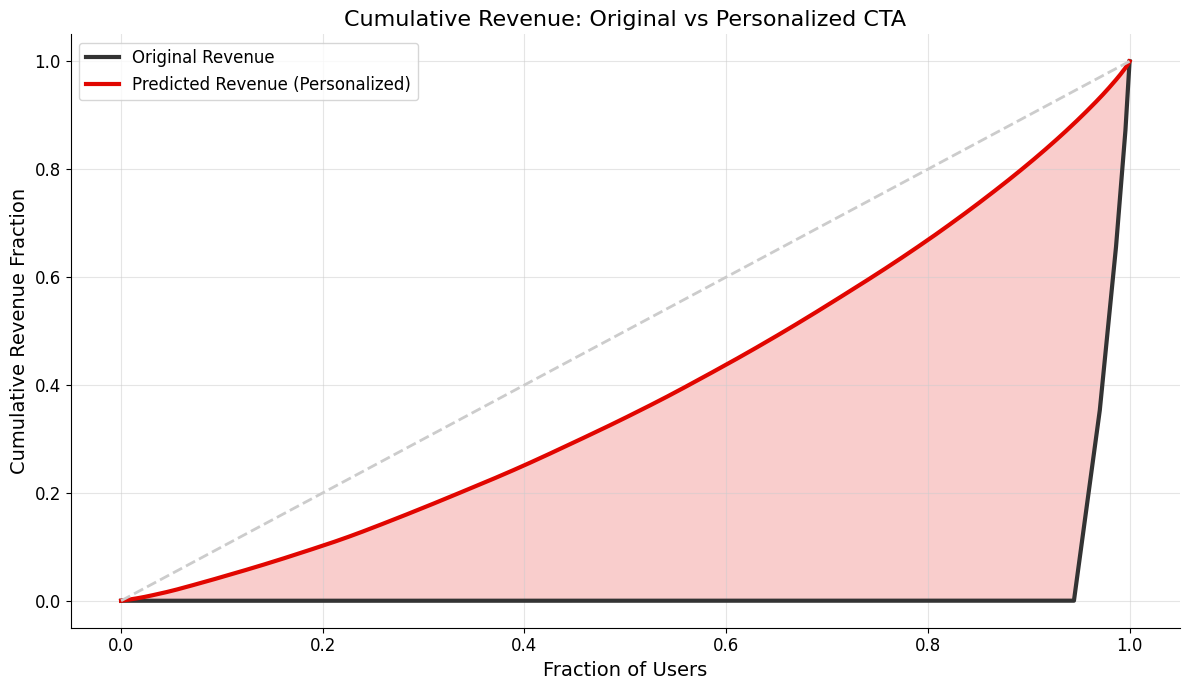

In [ ]:
original_sorted = np.sort(df['revenue'])
predicted_sorted = np.sort(preds_full["predicted_rpd"])

original_cum = np.cumsum(original_sorted) / np.sum(original_sorted)
predicted_cum = np.cumsum(predicted_sorted) / np.sum(predicted_sorted)
user_frac = np.linspace(0, 1, len(original_sorted))
rv_red = "#E10600"
dark_gray = "#333333"
light_gray = "#CCCCCC"
plt.figure(figsize=(12, 7))

plt.plot(user_frac, original_cum, label='Original Revenue', linewidth=3, color=dark_gray)
plt.plot(user_frac, predicted_cum, label='Predicted Revenue (Personalized)', linewidth=3, color=rv_red)
plt.plot([0, 1], [0, 1], '--', color=light_gray, linewidth=2)
plt.fill_between(user_frac, original_cum, predicted_cum, where=(predicted_cum > original_cum),
                 color=rv_red, alpha=0.2, interpolate=True)

plt.xlabel('Fraction of Users', fontsize=14)
plt.ylabel('Cumulative Revenue Fraction', fontsize=14)
plt.title('Cumulative Revenue: Original vs Personalized CTA', fontsize=16)
plt.legend(frameon=True, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color=light_gray, linestyle='-', linewidth=0.8, alpha=0.5)

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()